In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
import math
import pickle
import keras_tuner as kt

%matplotlib inline


print(tf.__version__)

2.14.0


## Image analysis

Number of images: 10344
Median: 87.0
Min: 46
Max: 1138
Last non-outlier dimension: 195


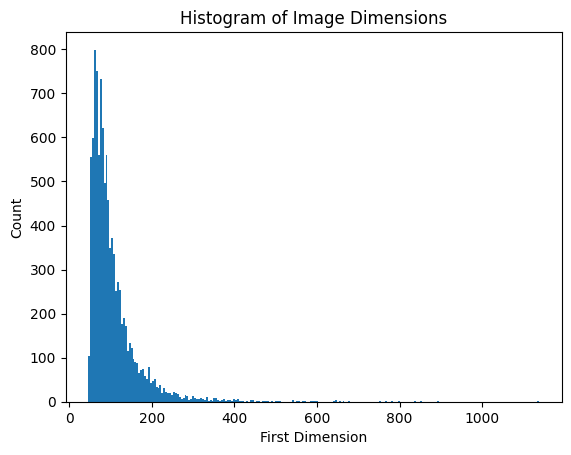

In [80]:
dataset = "mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        img = os.path.join(i, j)

        if "synthesized" in img:

            for synth in os.listdir(img):
                img3 = os.path.join(img, synth)

                img2 = Image.open(img3)
                img_array = np.array(img2)
                dimensions.append(img_array.shape[0])
                img_array = np.expand_dims(img_array, axis=-1)
        else:
            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

q1 = np.percentile(dimensions, 25)
q3 = np.percentile(dimensions, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
dimensions = np.sort(np.array(dimensions))
first_outlier = np.where((dimensions < q1 - threshold) | (dimensions > q3 + threshold))[
    0
]
print("Last non-outlier dimension:", dimensions[first_outlier[0] - 1])


plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

## Image augmentation


In [16]:
confirmed_num = 0

confirmed_num += len(os.listdir(dirs[0]))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0

for filename in os.listdir(dirs[1]):
    if "synthesized" in filename:
        rejected_images += [
            os.path.join(dirs[1], filename, synth)
            for synth in os.listdir(os.path.join(dirs[1], filename))
        ]
    else:
        rejected_images.append(os.path.join(dirs[1], filename))

rejected_num = len(rejected_images)
print("Number of artifact images:", rejected_num)

Number of meteor images: 8500
Number of artifact images: 1844


In [93]:
data_augmentation = tf.keras.Sequential(
    [layers.RandomRotation(0.5), layers.RandomZoom((-0.5, 0.25))]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    if "synthesized" in random_image_path:
        continue
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of meteor images:", confirmed_num)
print("Number of artifact images:", rejected_num)

Classes balanced.
Number of meteor images: 2822
Number of artifact images: 2822


## Dataset creation


In [81]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
IMG_SIZE = dimensions[first_outlier[0] - 1]
BATCH_SIZE = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)

class_names = train_ds.class_names

Found 10344 files belonging to 2 classes.
Using 7241 files for training.
Using 3103 files for validation.


### Dataset normalization


In [82]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    #image = tf.image.per_image_standardization(image)   model performs a bit worse with this on

    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Dataset visualization

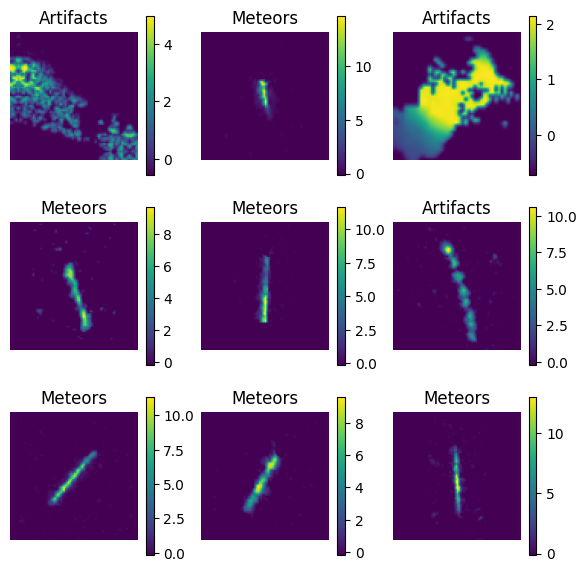

In [97]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

## Model creation


In [87]:
# initial model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133

model_name = "CNN_20240505_2"
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = models.Sequential()
        model._name = model_name

        # model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
        # model.add(layers.Rescaling(1.0 / 255))

        model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)))
        if hp.Boolean("normalize"):
            model.add(layers.Normalization())
        for i in range(hp.Int("num_conv_layers", 1, 3)):

            model.add(
                layers.Conv2D(
                    hp.Int(
                        f"conv_filter_num_{i}",
                        min_value=2 + 3 * i,
                        max_value=10 + 5 * i,
                        step=2,
                    ),
                    hp.Int(f"conv_kernel_{i}", 3, 10),
                    activation="relu",
                )
            )
            if i==0:
                model.add(layers.Dropout(rate=0.2))
                model.add(
                    layers.MaxPooling2D(
                        hp.Int(f"max_kernel_{i}", 2, 6),
                        strides=hp.Int(f"max_stride_{i}", 1, 5),
                    )
                )
            else:
                if hp.Boolean(f"dropout_{i}"):
                    model.add(layers.Dropout(rate=hp.Float(f"dropout_rate_{i}", 0.1, 0.2,0.05)))
                if hp.Boolean(f"maxpool_{i}"):
                    model.add(
                        layers.MaxPooling2D(
                            hp.Int(f"max_kernel_{i}", 2, 6),
                            strides=hp.Int(f"max_stride_{i}", 1, 5),
                        )
                    )

        model.add(layers.Flatten())

        if hp.Boolean("2nd_dense"):
            model.add(
                layers.Dense(
                    units=hp.Int("dense_units", min_value=16, max_value=128, step=16),
                    activation="relu",
                )
            )
        model.add(layers.Dense(1, activation="sigmoid"))

        # hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
        model.compile(
            loss=(
                losses.BinaryCrossentropy()
                if hp.Boolean("bc_loss")
                else losses.BinaryFocalCrossentropy(apply_class_balancing=True)
            ),
            optimizer=optimizers.Adam(
                learning_rate=hp.Choice("learning_rate", values=[1e-3, 1e-4])
            ),
            metrics=[
                tf.keras.metrics.F1Score(name="f1", threshold=0.5, average="micro"),
                tf.keras.metrics.FalseNegatives(name="fn"),
            ],
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )
    def predict(self,model,validation_data,verbose=1):
        return model.predict(validation_data,verbose=verbose)

### Tuning setup

In [88]:
tuner = kt.Hyperband(
    MyHyperModel(),
    objective=kt.Objective("val_fn", direction="min"),
    max_epochs=15,
    factor=3,
    directory="keras_tuner",
    project_name="GMNmeteorNet",
    overwrite=True,
)
#tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(train_ds, epochs=2, validation_data=val_ds,
             callbacks=[stop_early])




Trial 30 Complete [00h 01m 02s]
val_fn: 3.0

Best val_fn So Far: 3.0
Total elapsed time: 00h 07m 46s


In [89]:
best_hp = tuner.get_best_hyperparameters()[0]

all_hyperparameters = best_hp.values
print(all_hyperparameters)
hypermodel = MyHyperModel()
# Get the optimal hyperparameters
model = hypermodel.build(best_hp)
model._name = model_name
model.summary()

{'normalize': True, 'num_conv_layers': 1, 'conv_filter_num_0': 6, 'conv_kernel_0': 7, 'max_kernel_0': 3, 'max_stride_0': 3, '2nd_dense': False, 'bc_loss': True, 'learning_rate': 0.0001, 'dense_units': 80, 'shuffle': False, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Model: "CNN_20240505_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 195, 195, 1)       3         
 on)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 189, 189, 6)       300       
                                                                 
 dropout_2 (Dropout)         (None, 189, 189, 6)       0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 6)         0         
 g2D)     

In [92]:
json_config = model.to_json()
with open(f"models/{model_name}_config.json", "w") as json_file:
    json_file.write(json_config)

### Model architecture loading

In [ ]:
with open(f"models/{model_name}_config.json", "r") as json_file:
    json_config = json_file.read()
model = models.model_from_json(json_config)

### Training model

In [90]:
EPOCHS = 20
history = hypermodel.fit(best_hp,model,train_ds, epochs=EPOCHS, validation_data=val_ds)

val_f1_per_epoch = history.history["val_f1"]
best_epoch2 = val_f1_per_epoch.index(max(val_f1_per_epoch)) + 1
print(f"Best val_f1 epoch: {best_epoch2}")

Epoch 1/20
227/227 [==============================] - 4s 12ms/step - loss: 0.3217 - f1: 0.9495 - fn: 225.0000 - val_loss: 0.1538 - val_f1: 0.9752 - val_fn: 7.0000
Epoch 2/20
227/227 [==============================] - 2s 9ms/step - loss: 0.1287 - f1: 0.9774 - fn: 24.0000 - val_loss: 0.1236 - val_f1: 0.9782 - val_fn: 8.0000
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 0.1171 - f1: 0.9792 - fn: 27.0000 - val_loss: 0.1155 - val_f1: 0.9798 - val_fn: 10.0000
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.1105 - f1: 0.9808 - fn: 24.0000 - val_loss: 0.1139 - val_f1: 0.9809 - val_fn: 15.0000
Epoch 5/20
227/227 [==============================] - 2s 9ms/step - loss: 0.1051 - f1: 0.9815 - fn: 20.0000 - val_loss: 0.1135 - val_f1: 0.9830 - val_fn: 16.0000
Epoch 6/20
227/227 [==============================] - 2s 9ms/step - loss: 0.1009 - f1: 0.9830 - fn: 22.0000 - val_loss: 0.1028 - val_f1: 0.9828 - val_fn: 12.0000
Epoch 7/20
227/227 [========

In [91]:
model.save(f"models/{model_name}.keras")

with open(f"models/{model_name}_history.pkl", "wb") as f:
    pickle.dump(history, f)

### Loading model

In [104]:
model = models.load_model("models/CNN_20240505_1.keras")

In [169]:
with open(f"models/{model_name}_history.pkl", "rb") as f:
    history = pickle.load(f)

### Model Evaluation

In [37]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on the validation dataset
results = model.evaluate(val_ds)
print
# Print the evaluation results
print("Loss:", results[0])
print("Accuracy:", results[1])


97/97 [==============================] - 1s 6ms/step - loss: 0.6933 - accuracy: 0.5869
Loss: 0.6933495998382568
Accuracy: 0.5868514180183411


## Result analysis

### Training results

Validation F1-Score: 0.9860896468162537


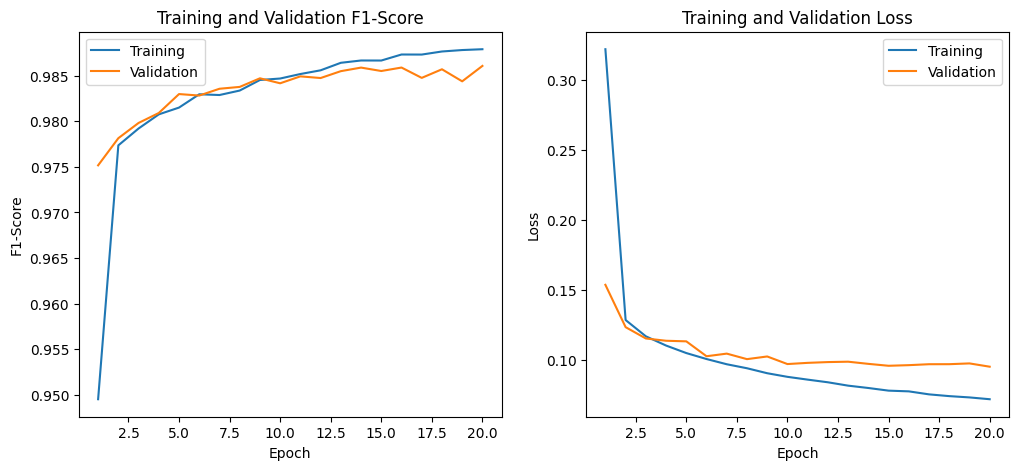

In [93]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
f1 = history.history["f1"]
val_f1 = history.history["val_f1"]

print("Validation F1-Score:", val_f1[-1])


epoch_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, f1, label="Training")
plt.plot(epoch_range, val_f1, label="Validation")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [94]:
Y_pred = hypermodel.predict(model,val_ds)

97/97 [==============================] - 1s 5ms/step


### Confusion matrix

In [95]:
#print(Y_pred)
Y_pred_labels = np.squeeze(np.round(Y_pred))

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_labels, num_classes=2).numpy()
print("True positives:", confusion_mtx[1][1])
print("True negatives:", confusion_mtx[0][0])
print("False positives:", confusion_mtx[0][1])
print("False negatives:", confusion_mtx[1][0])
false_negatives = confusion_mtx[1][0]
false_positives = confusion_mtx[0][1]

True positives: 2552
True negatives: 479
False positives: 64
False negatives: 8


False negatives: 8
False positives: 64


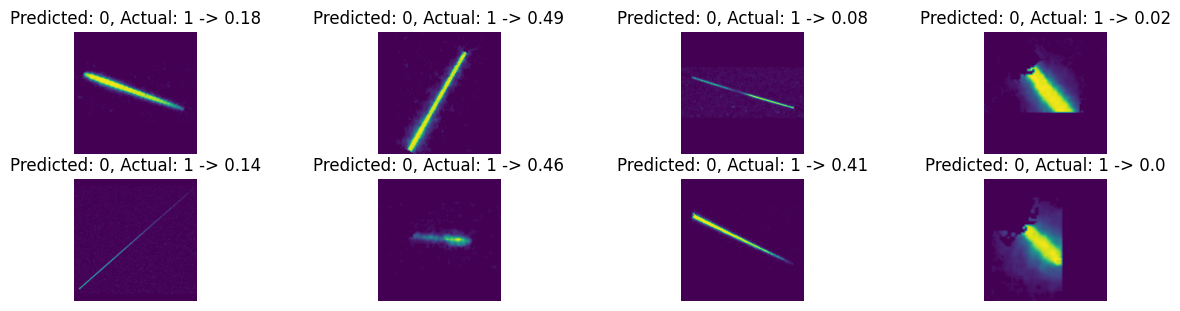

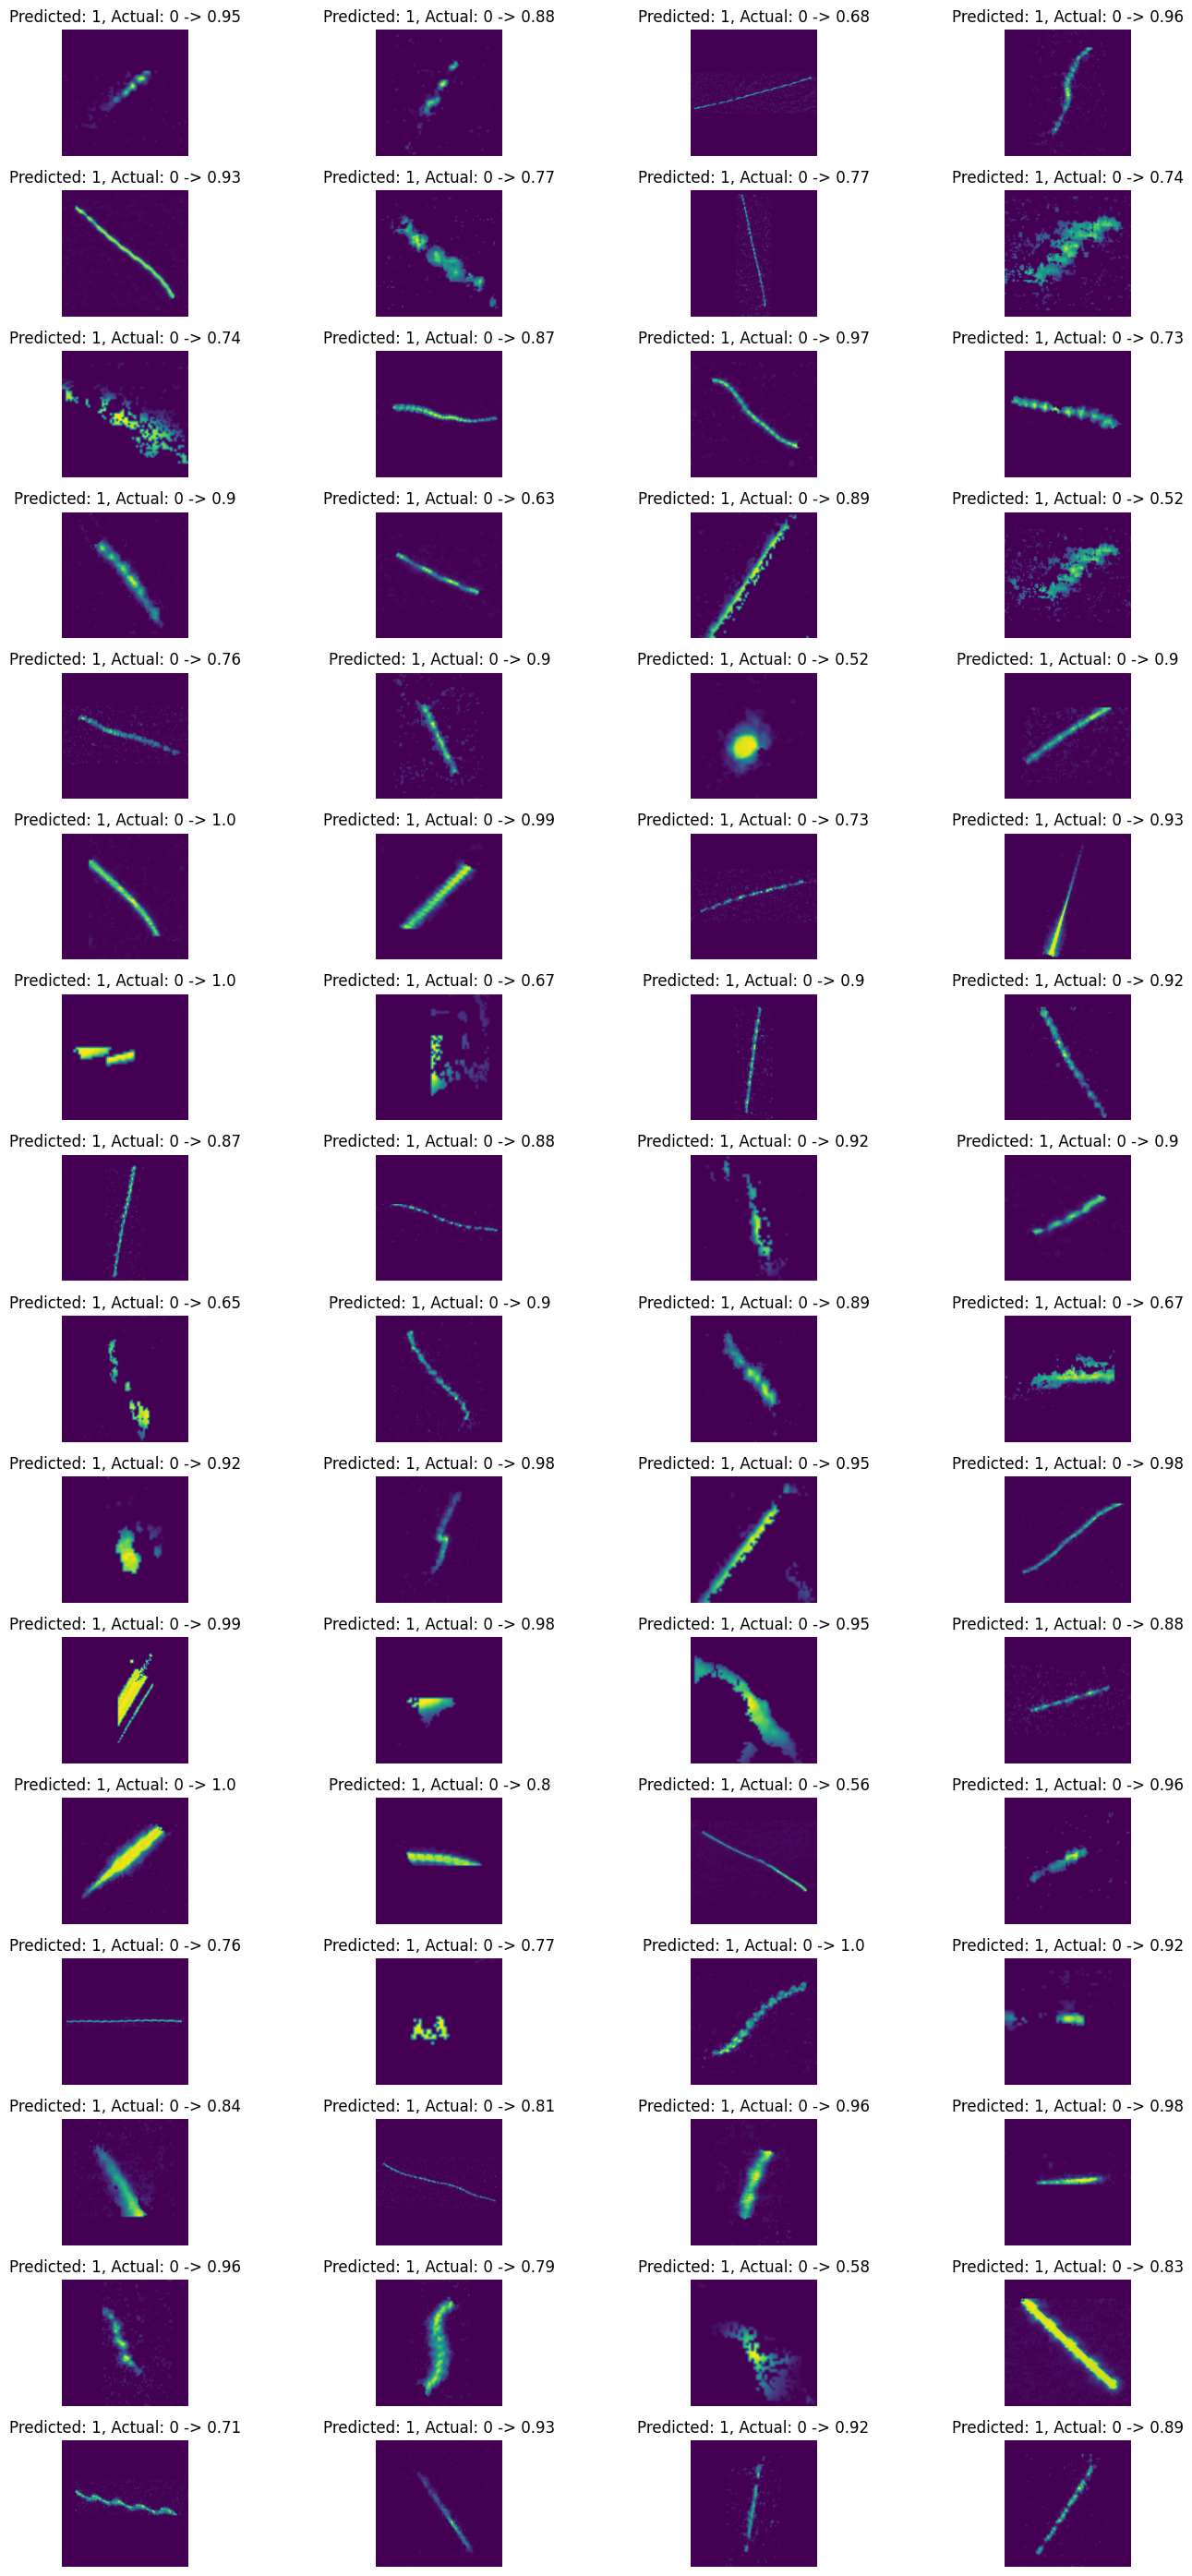

In [96]:

columns_num = 4
fig, axes = plt.subplots(
    math.ceil(false_negatives / columns_num), columns_num, figsize=(15, 7*math.ceil(false_negatives / columns_num)/4)
)
fig2, axes2 = plt.subplots(
    math.ceil(false_positives / columns_num), columns_num, figsize=(15, 7*math.ceil(false_positives / columns_num)/4)
)
for ax in axes.flatten():
    ax.axis("off")
for ax in axes2.flatten():
    ax.axis("off")

plt.subplots_adjust(hspace=0.05)
counter = 0
counter2 = 0
for i, (img, true_label) in enumerate(val_ds.unbatch()):
    if Y_pred_labels[i] == 0 and true_label == 1:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = hypermodel.predict(model,img2, verbose=0)
        row = counter // columns_num
        col = counter % columns_num
        counter += 1
        prediction_confidence = str(round(prediction[0][0], 2))

        if math.ceil(false_negatives / columns_num) > 1:
            axes[row, col].imshow(img)
            axes[row, col].set_title(
                f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
            )
        else:
            axes[col].imshow(img)
            axes[col].set_title(
                f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
            )

    elif Y_pred_labels[i] == 1 and true_label == 0:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = hypermodel.predict(model,img2, verbose=0)
        row = counter2 // columns_num
        col = counter2 % columns_num
        counter2 += 1
        axes2[row, col].imshow(img)
        prediction_confidence = str(round(prediction[0][0], 2))
        axes2[row, col].set_title(
            f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
        )
print("False negatives:", counter)
print("False positives:", counter2)
plt.tight_layout()
plt.show()

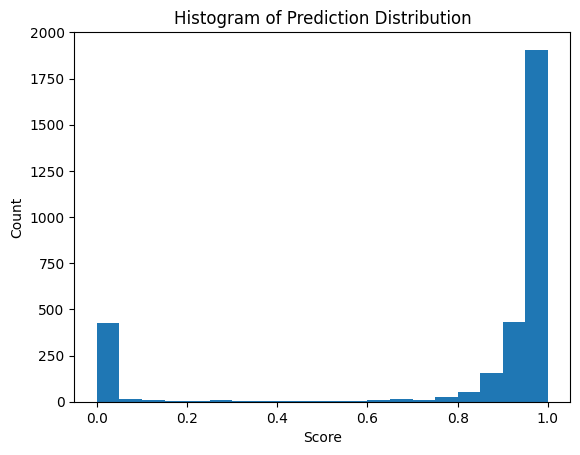

In [97]:
plt.hist(Y_pred, bins=20)

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Histogram of Prediction Distribution")
plt.show()

### Predicting single example

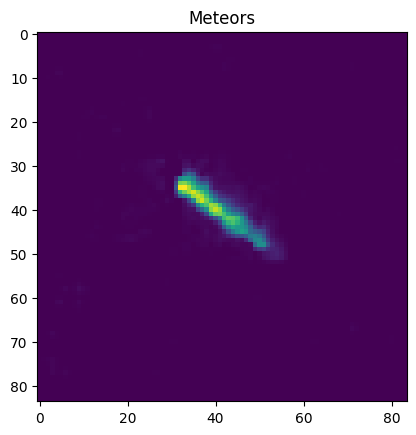

1/1 [==============================] - 0s 15ms/step
Prediction:           0.9997503161430359 - > True


In [122]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = hypermodel.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))] == class_names[int(lab[0])]}"
    )
    break

### Testing Fiachra's model


Correct predictions: 118 / 294
Test accuracy: [0.40136054]


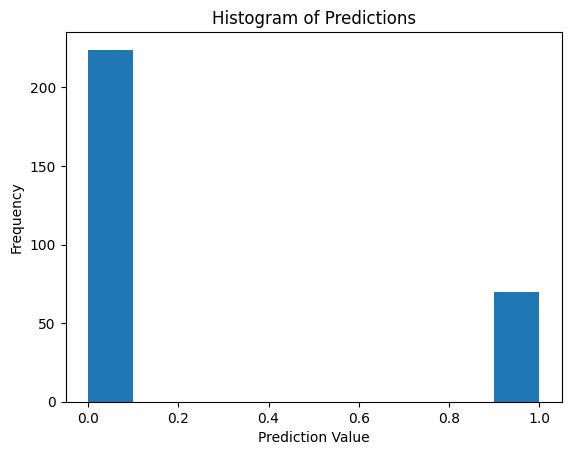

In [123]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
predictions = []
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]

    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        # print(output_data)
        # print(np.round(output_data)[0][0])

        # Get the highest scoring class
        prediction = int(np.round(output_data)[0][0])
        # print(prediction)
        predictions.append(prediction)
        # break
        correct_predictions += prediction == label_batch[i].numpy()


print("Correct predictions:", correct_predictions[0], "/", total_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)
plt.hist(predictions, bins="auto")
plt.title("Histogram of Predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")
plt.show()

Reason for such poor performance of the .tflite model is suspected to be because of drastic image resize to 32px where important image features might be lost making image classification difficult.